# Customer Service Chatbot with DialogGPT for Conversational Intents

This Jupyter Notebook updates `evaluate_chatbot_data_dialoggpt_twitter_trained.ipynb` to fix syntax errors and a class mismatch error in model evaluation (5 classes vs. 11 target names). It uses Microsoft’s DialogGPT for conversational intents (greeting, farewell, small_talk, compliment, weather_query) and DistilBERT for trucking-specific intents (delivery_status, billing_issue, account_update, service_inquiry, fuel_card_query, general_query). Trains on Twitter dataset (`tweets.csv` or `trucking_chatbot_test_dataset.csv`) with interactive ipywidgets UI.

## Objectives
- Inspect Twitter dataset for intents and entities (e.g., location, company).
- Train DistilBERT for intent classification.
- Fine-tune DialogGPT on conversational Twitter data.
- Evaluate DistilBERT with accuracy, F1-score, confusion matrix, and dialogue success rate.
- Implement hybrid dialogue management with DialogGPT and DistilBERT.
- Provide interactive UI for customer interaction.

## Requirements
- Python 3.8 (recommended; 3.9 also compatible)
- Install: `pip install transformers==4.44.2 torch==2.5.0 pandas==2.2.3 numpy==2.1.1 scikit-learn==1.5.2 datasets==3.0.1 seaborn==0.13.2 matplotlib==3.9.2 ipywidgets==8.1.5`
- For GPU: `pip install torch==2.5.0+cu121 --index-url https://download.pytorch.org/whl/cu121`
- Place `trucking_chatbot_test_dataset.csv` or `tweets.csv` in the directory.
- Enable widgets: `jupyter nbextension enable --py widgetsnbextension`

## Notes
- Dataset: https://www.kaggle.com/thoughtvector/customer-support-on-twitter
- Reflects tariffs/Moody’s downgrade in billing/fuel inquiries.
- Professional responses with dynamic DialogGPT conversation.
- Date: May 29, 2025, 1:44 PM EDT


In [1]:
!pip install transformers==4.44.2 torch==2.6.0 pandas==2.2.2 numpy==1.25.0 scikit-learn==1.5.2 datasets seaborn==0.13.2 matplotlib==3.9.2 ipywidgets==7.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 139.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
pip install --no-cache-dir --upgrade jaraco.functools

In [2]:
pip install --no-cache-dir --upgrade accelerate

## Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset, ClassLabel
import torch
import json
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict
import random
import re
from datetime import datetime
import os
from matplotlib.pyplot import text
%matplotlib inline


## Step 2: Inspect and Preprocess Dataset

Load Twitter dataset, add conversational examples, label intents/entities. Ensure all intents are preserved.


In [5]:
def load_dataset(file_path='/content/sample_data/twcs.csv'):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print('Dataset not found. Using Twitter dataset.')
        try:
            df = pd.read_csv('tweets.csv')
        except FileNotFoundError:
            print('Download from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter')
            data = {
                'text': [
                    'Where is my shipment from Speedway?', 'Why is my Comdata bill so high?',
                    'Need to update my address for IFTA', 'What are your hauling rates?',
                    'Help with my account', 'Hello', 'How are you', 'How can I help you',
                    'Track my cargo', 'Overcharged on Comdata invoice', 'Hi there',
                    'Change my contact info', 'Tell me about Comdata services', 'Lost my shipment',
                    'Good morning', 'Thanks for your help', 'Bye', 'What’s new?',
                    'How’s it going?', 'How’s your day going?', 'Any big plans?',
                    'How’s the trucking life?', 'You’re awesome!', 'Great job!',
                    'How’s the weather there?', 'Is it raining?',
                    'How do I get to Chicago?', 'What’s the best route to Miami?',
                    'Directions to the nearest truck stop', 'Can you route me to Denver?',
                    'Address is not correct on card', 'Update my billing address',
                    'Wrong address on my account', 'Change address for fuel card',
                    'My Comdata card is not working', 'Comdata card declined at pump',
                    'Fix my Comdata card issue', 'Why isn’t my Comdata card accepted?',
                    'I am not able to login to the Driven website', 'Can’t access my account on Driven',
                    'Login error on the Driven website', 'Driven website login not working',
                    'I want to change my card pin on the Driven website', 'Update my fuel card PIN on Driven',
                    'Need to reset my card PIN for Driven', 'Change PIN for my Comdata card on Driven website'
                ],
                'intent': [
                    'delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                    'general_query', 'greeting', 'greeting', 'greeting', 'delivery_status',
                    'billing_issue', 'greeting', 'account_update', 'fuel_card_query',
                    'general_query', 'greeting', 'farewell', 'farewell', 'small_talk',
                    'small_talk', 'small_talk', 'small_talk', 'small_talk', 'compliment',
                    'compliment', 'weather_query', 'weather_query',
                    'direction', 'direction', 'direction', 'direction',
                    'account_update', 'account_update', 'account_update', 'account_update',
                    'fuel_card_query', 'fuel_card_query', 'fuel_card_query', 'fuel_card_query',
                    'login_issue', 'login_issue', 'login_issue', 'login_issue',
                    'account_update', 'account_update', 'account_update', 'account_update'
                ]
            }
            df = pd.DataFrame(data)
    return df
df = load_dataset()

In [12]:
df.head()

,text
0,I understand. I would like to assist you. We ...
3,Please send us a Private Message so that we c...
5,"Can you please send us a private message, so ..."
7,This is saddening to hear. Please shoot us a ...
9,We understand your concerns and we'd like for...


Dropping inbound messages as the Bot needs to be trained only on outbound responses, and clean up the user id references

In [7]:
df=df[df['inbound']==False]

Dropping tweet_id,inbound, author_id, created_at response_Tweet_id, in_response_to_tweet_id columns as they are not relevent to the program

In [9]:
df = df.drop(['tweet_id','inbound','author_id','created_at','response_tweet_id','in_response_to_tweet_id'],axis=1)

Removing refererences of ID from the text response

In [11]:
df['text']= df['text'].replace('(@\d+)', '', regex=True)

In [18]:
import pandas as pd
import random

def inspect_dataset(df):
    # Define expected intents
    expected_intents = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                        'fuel_card_query', 'general_query', 'greeting', 'farewell',
                        'small_talk', 'compliment', 'weather_query', 'direction', 'login_issue']

    # Check for null values
    if 'text' in df.columns:
        df = df.dropna(subset=['text'])
    if 'intent' in df.columns:
        df = df.dropna(subset=['intent'])

    keywords = ['delivery', 'shipment', 'cargo', 'bill', 'invoice', 'payment', 'account',
                'service', 'hauling', 'truck', 'comdata', 'ifta', 'speedway', 'fuel',
                'tax', 'station', 'hello', 'hi', 'how', 'good', 'bye', 'thanks', 'new',
                'day', 'plans', 'awesome', 'great', 'weather', 'rain', 'direction',
                'route', 'get to', 'truck stop', 'address', 'card', 'login', 'website', 'portal', 'pin', 'driven',
                'sign in', 'access', 'failed']
    if 'text' in df.columns:
        df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]

    if 'intent' not in df.columns:
        def label_intent(text):
            text = text.lower()
            if any(word in text for word in ['pin', 'change pin', 'reset pin', 'card pin']):
                return 'account_update'
            elif any(word in text for word in ['login', 'access account', 'website login', 'portal', 'login error', 'sign in', 'failed']):
                return 'login_issue'
            elif any(word in text for word in ['comdata', 'fuel card', 'card declined', 'card not working', 'card issue']):
                return 'fuel_card_query'
            elif any(word in text for word in ['address', 'update address', 'wrong address', 'billing address', 'card address']):
                return 'account_update'
            elif any(word in text for word in ['direction', 'route', 'get to', 'truck stop']):
                return 'direction'
            elif any(word in text for word in ['hello', 'hi', 'how are you', 'how can i help', 'good morning', 'good afternoon']):
                return 'greeting'
            elif any(word in text for word in ['goodbye', 'bye', 'thanks', 'thank you']):
                return 'farewell'
            elif any(word in text for word in ['what’s new', 'how’s it going', 'how’s your day', 'any big plans', 'trucking life']):
                return 'small_talk'
            elif any(word in text for word in ['awesome', 'great job', 'you rock']):
                return 'compliment'
            elif any(word in text for word in ['weather', 'rain', 'sunny']):
                return 'weather_query'
            elif any(word in text for word in ['delivery', 'shipment', 'track', 'cargo']):
                return 'delivery_status'
            elif any(word in text for word in ['bill', 'invoice', 'payment', 'charge']):
                return 'billing_issue'
            elif any(word in text for word in ['update', 'change', 'contact']) and 'address' not in text:
                return 'account_update'
            else:
                return 'general_query'
        df['intent'] = df['text'].apply(label_intent)

    def extract_entities(text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        if 'ifta' in text:
            entities.append({'entity': 'regulation', 'value': 'IFTA'})
        if any(word in text for word in ['chicago', 'miami', 'denver', 'dallas', 'atlanta', 'phoenix']):
            entities.append({'entity': 'destination', 'value': text.split()[-1].capitalize()})
        if 'address' in text:
            entities.append({'entity': 'address', 'value': 'address'})
        if any(word in text for word in ['login', 'sign in', 'access']):
            entities.append({'entity': 'login', 'value': 'login'})
        if 'pin' in text:
            entities.append({'entity': 'pin', 'value': 'pin'})
        if 'driven' in text:
            entities.append({'entity': 'website', 'value': 'Driven'})
        return entities

    df['entities'] = df['text'].apply(extract_entities)

     # Ensure all intents and sufficient samples
    intent_counts = df['intent'].value_counts()
    missing_intents = [intent for intent in expected_intents if intent not in df['intent'].unique()]
    if missing_intents or any(intent_counts.get(intent, 0) < 5 for intent in expected_intents):
        print(f'Warning: Missing intents {missing_intents} or low sample counts {intent_counts.to_dict()}. Adding placeholders.')
        placeholder_data = []
        for intent in expected_intents:
            current_count = intent_counts.get(intent, 0)
            if current_count < 5:
                for _ in range(5 - current_count):
                    if intent == 'account_update':
                        placeholder_data.append({'text': f'{random.choice(["Update my", "Change my", "Reset my"])} {random.choice(["address", "billing address", "card pin"])} on {random.choice(["Driven website", "Driven"])}', 'intent': 'account_update', 'entities': [{'entity': 'address', 'value': 'address'}] if 'address' in random.choice(["address", "billing address"]) else [{'entity': 'pin', 'value': 'pin'}, {'entity': 'website', 'value': 'Driven'}]})
                    elif intent == 'login_issue':
                        placeholder_data.append({'text': f'{random.choice(["Can’t login to", "Unable to access", "Problem logging into", "Login failed on", "Can’t sign in to"])} the Driven {random.choice(["website", "portal"])}', 'intent': 'login_issue', 'entities': [{'entity': 'login', 'value': 'login'}, {'entity': 'website', 'value': 'Driven'}]})
                    elif intent == 'fuel_card_query':
                        placeholder_data.append({'text': f'My {random.choice(["Comdata card", "fuel card"])} {random.choice(["is not working", "was declined", "has an issue"])}', 'intent': 'fuel_card_query', 'entities': [{'entity': 'company', 'value': 'Comdata'}]})
                    elif intent == 'direction':
                        placeholder_data.append({'text': f'How do I get to {random.choice(["Dallas", "Atlanta", "Phoenix"])}?', 'intent': 'direction', 'entities': [{'entity': 'destination', 'value': random.choice(["Dallas", "Atlanta", "Phoenix"])}]})
                    elif intent == 'compliment':
                        placeholder_data.append({'text': f'You guys are {random.choice(["great", "awesome", "fantastic"])}!', 'intent': 'compliment', 'entities': []})
                    elif intent == 'weather_query':
                        placeholder_data.append({'text': f'Is it {random.choice(["raining", "sunny", "snowing"])} on my route?', 'intent': 'weather_query', 'entities': []})
                    elif intent == 'farewell':
                        placeholder_data.append({'text': f'{random.choice(["Thanks, bye", "Goodbye", "See ya"])}!', 'intent': 'farewell', 'entities': []})
                    elif intent == 'small_talk':
                        placeholder_data.append({'text': f'{random.choice(["How’s the day going?", "What’s new with you?", "How’s trucking?"])}', 'intent': 'small_talk', 'entities': []})
                    elif intent == 'greeting':
                        placeholder_data.append({'text': f'{random.choice(["Hello", "Hi", "Good morning"])}!', 'intent': 'greeting', 'entities': []})
                    elif intent == 'delivery_status':
                        placeholder_data.append({'text': f'Track my shipment {random.randint(100, 999)}', 'intent': 'delivery_status', 'entities': []})
                    elif intent == 'billing_issue':
                        placeholder_data.append({'text': f'Why is my bill ${random.randint(100, 1000)}?', 'intent': 'billing_issue', 'entities': []})
                    elif intent == 'service_inquiry':
                        placeholder_data.append({'text': f'What are your {random.choice(["rates", "services", "routes"])}?', 'intent': 'service_inquiry', 'entities': []})
                    elif intent == 'general_query':
                        placeholder_data.append({'text': f'Need help with {random.choice(["something", "my account", "a question"])}', 'intent': 'general_query', 'entities': []})
        if placeholder_data:
            df = pd.concat([df, pd.DataFrame(placeholder_data)], ignore_index=True)

    print('Dataset Shape:', df.shape)
    print('Columns:', df.columns.tolist())
    print('Sample Rows:\n', df.head())
    print('Missing Values:\n', df.isnull().sum())
    print('Intent Distribution:\n', df['intent'].value_counts())
    print('Unique Intents:', sorted(df['intent'].unique()))
    print('Entity Samples:\n', df[df['entities'].apply(len) > 0][['text', 'entities']].head())
    return df, expected_intents

df, expected_intents = inspect_dataset(df)

Dataset Shape: (330595, 3)
Columns: ['text', 'intent', 'entities']
Sample Rows:
                                                 text         intent  \
0   Can you please send us a private message, so ...  general_query   
1   This is saddening to hear. Please shoot us a ...       greeting   
2   H there! We'd definitely like to work with yo...       greeting   
3   Please send me a private message so that I ca...  general_query   
4   Our department is part of the corporate offic...       greeting   

                                  entities  
0                                       []  
1                                       []  
2                                       []  
3  [{'entity': 'login', 'value': 'login'}]  
4                                       []  
Missing Values:
 text        0
intent      0
entities    0
dtype: int64
Intent Distribution:
 intent
greeting           211340
general_query       41879
account_update      39579
farewell            22598
delivery_status  

## Step 3: Prepare DialogGPT Training Data


In [19]:
def prepare_dialoggpt_training_data(df):
    conversational_intents = ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    df_conversational = df[df['intent'].isin(conversational_intents)][['text', 'intent']]

    # Validate dataset
    if df_conversational.empty:
        raise ValueError("No conversational intents found in dataset. Check Cell 2 output.")

    # Check intent distribution
    intent_counts = df_conversational['intent'].value_counts()
    print('Conversational Intent Distribution:')
    for intent in conversational_intents:
        count = intent_counts.get(intent, 0)
        print(f'{intent}: {count}')
        if count < 5:
            raise ValueError(f"Intent {intent} has {count} samples (<5). Add more samples in Cell 2.")

    response_map = {
        'greeting': [
            'Hello! How can I assist you with your trucking needs today?',
            'Hi there! Ready to help with your shipments or account!',
            'Good to hear from you! What’s up?'
        ],
        'farewell': [
            'Goodbye! Stay safe on the road.',
            'Thanks for connecting!'
        ],
        'small_talk': [
            'My day’s going smoothly, thanks! How’s yours?',
            'Trucking life’s always moving! How’s it like for you?',
            'Just keeping the wheels turning! Got any big plans?',
            'All’s good here! What’s new with you?'
        ],
        'compliment': [
            'Thanks, you’re awesome too! Need help with anything?',
            'Appreciate that! What can I do for you today?'
        ],
        'weather_query': [
            'Can’t see the skies, but I can check your route! Where are you headed?',
            'Weather’s a mystery here, but I’m ready to help! What’s your destination?'
        ]
    }

    dialogues = []
    for _, row in df_conversational.iterrows():
        user_input = row['text']
        intent = row['intent']
        response = random.choice(response_map[intent])
        dialogues.append({'input': user_input, 'response': response})

    dialogue_df = pd.DataFrame(dialogues)
    dataset = Dataset.from_pandas(dialogue_df)

    # Manual train/eval split (80/20)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices = indices[:split_idx]
    eval_indices = indices[split_idx:]
    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)

    os.makedirs('data', exist_ok=True)
    dialogue_df.to_csv('data/dialoggpt_dialogues.csv', index=False)

    print(f'DialogGPT training data prepared: {len(dialogue_df)} dialogue pairs.')
    print(f'Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}')
    return train_dataset, eval_dataset

dialoggpt_train_dataset, dialoggpt_eval_dataset = prepare_dialoggpt_training_data(df)

Conversational Intent Distribution:
greeting: 211340
farewell: 22598
small_talk: 5
compliment: 1116
weather_query: 1593
DialogGPT training data prepared: 236652 dialogue pairs.
Train dataset size: 189321, Eval dataset size: 47331


## Step 4: Fine-Tune DialogGPT


In [20]:
from ast import Not
import torch
import os

def load_saved_model(model_path='./dialoggpt_model'):
    """Load a saved DialogGPT model and tokenizer."""
    try:
        if not os.path.exists(model_path):
            print(f"No saved model found at {model_path}. Using pretrained model.")
            return None, None
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Loaded model and tokenizer from {model_path}.")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading saved model: {e}")
        return None, None

def fine_tune_dialoggpt(train_dataset, eval_dataset, force_fine_tune=False):
    if not force_fine_tune:
      # Try loading saved model first
      model, tokenizer = load_saved_model()
      if model is not None and tokenizer is not None:
          return model, tokenizer

    # If no saved model, proceed with fine-tuning
    model_name = 'microsoft/DialoGPT-medium'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    def preprocess_dialogues(example):
        try:
            conversation = f"{example['input']} {tokenizer.eos_token} {example['response']}"
            tokenized = tokenizer(
                conversation,
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )
            result = {
                'input_ids': tokenized['input_ids'].squeeze(0),
                'attention_mask': tokenized['attention_mask'].squeeze(0),
                'labels': tokenized['input_ids'].squeeze(0).clone()
            }
            return result
        except Exception as e:
            print(f'Error in preprocess_dialogues: {e}')
            raise

    try:
        tokenized_train_dataset = train_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing train dataset",
            #disable_progress_bar=True
        )
        tokenized_eval_dataset = eval_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing eval dataset",
            #disable_progress_bar=True
        )
        tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    except Exception as e:
        print(f'Error tokenizing dataset: {e}')
        return None, None

    training_args = TrainingArguments(
        output_dir='./dialoggpt_results',
        num_train_epochs=3,
        per_device_train_batch_size=3,
        per_device_eval_batch_size=3,
        warmup_steps=10,
        weight_decay=0.01,
        logging_dir='./dialoggpt_logs',
        logging_steps=20,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset
    )

    try:
        trainer.train()
        trainer.save_model('./dialoggpt_model')
        tokenizer.save_pretrained('./dialoggpt_model')
        print('DialogGPT model fine-tuned and saved.')
        return model, tokenizer
    except Exception as e:
        print(f'Error fine-tuning DialogGPT: {e}')
        print('Falling back to pretrained DialogGPT model.')
        return None, None

dialoggpt_model, dialoggpt_tokenizer = fine_tune_dialoggpt(dialoggpt_train_dataset, dialoggpt_eval_dataset,force_fine_tune=True)
if dialoggpt_model is None:
    print('Using pretrained DialogGPT due to fine-tuning error.')
    dialoggpt_model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer.pad_token = dialoggpt_tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Tokenizing train dataset:   0%|          | 0/189321 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/47331 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nisheeth_g2000 (nisheeth_g2000-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.452400,0.455502
2,0.404100,0.433278
3,0.378000,0.432382


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


DialogGPT model fine-tuned and saved.


## Cell 5: Test Inference: To test the loaded model for inference

In [21]:
def generate_response(input_text, model, tokenizer, max_length=50):
    inputs = tokenizer(input_text + tokenizer.eos_token, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_p=0.9
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    return response.split(tokenizer.eos_token)[-2].strip()

# Test the model
test_inputs = ["Hello!", "How’s the weather there?", "You’re awesome!"]
for input_text in test_inputs:
    response = generate_response(input_text, dialoggpt_model, dialoggpt_tokenizer)
    print(f"Input: {input_text}\nResponse: {response}\n")

Input: Hello!
Response: Good to hear from you! What’s up?

Input: How’s the weather there?
Response: Weather’s a mystery here, but I’m ready to help! What’s your destination?

Input: You’re awesome!
Response: Thanks, you’re awesome too! Need help with anything?



## Step 5: Preprocess for DistilBERT

Ensure all intents are included in the tokenized dataset and label_map.


In [22]:
def preprocess_data(df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    # Create label_map with all expected intents
    #expected_intents = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry', 'fuel_card_query',
                       # 'general_query', 'greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    label_map = {label: idx for idx, label in enumerate(sorted(expected_intents))}

    # Verify 'intent' column exists
    if 'intent' not in df.columns:
        raise ValueError("'intent' column missing in DataFrame. Check Cell 2 output.")

    # Filter dataset to include only expected intents
    df_filtered = df[df['intent'].isin(expected_intents)][['text', 'intent']].copy()

    # Check for empty dataset
    if df_filtered.empty:
        raise ValueError("Filtered dataset is empty. Check Cell 2 filtering or intent distribution.")

    # Check for missing intents and warn
    present_intents = df_filtered['intent'].unique()
    missing_intents = [intent for intent in expected_intents if intent not in present_intents]
    if missing_intents:
        print(f'Warning: Intents {missing_intents} missing in dataset after filtering.')

    dataset = Dataset.from_pandas(df_filtered)

    # Validate dataset size
    if len(dataset) == 0:
        raise ValueError("Dataset is empty after conversion. Check Cell 2 output.")

    # Compute label distribution
    label_counts = pd.Series([label_map.get(x['intent'], -1) for x in dataset]).value_counts()
    print('Label Distribution in Dataset (Label ID: Count):')
    for label_id, count in label_counts.items():
        if label_id == -1:
            print(f'Invalid Labels: {count}')
        else:
            intent = list(label_map.keys())[list(label_map.values()).index(label_id)]
            print(f'{intent} ({label_id}): {count}')

    # Check for invalid or insufficient labels
    if -1 in label_counts:
        raise ValueError(f"Invalid intents found: {label_counts[-1]} samples not in {expected_intents}.")
    min_samples = 5
    low_sample_labels = {label_id: count for label_id, count in label_counts.items() if count < min_samples and label_id != -1}
    if low_sample_labels:
        low_intents = {list(label_map.keys())[list(label_map.values()).index(k)]: v for k, v in low_sample_labels.items()}
        raise ValueError(f"Intents with < {min_samples} samples: {low_intents}. Add more samples in Cell 2.")

    # Tokenize and rename 'intent' to 'labels'
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column('intent', 'labels')
    tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': label_map[x['labels']]})
    tokenized_dataset = tokenized_dataset.cast_column('labels', ClassLabel(names=list(label_map.keys())))

    # Verify dataset features
    print('Dataset Features:\n', tokenized_dataset.features)
    return tokenized_dataset, label_map, tokenizer

dataset, label_map, tokenizer = preprocess_data(df)
print(f'Label Map: {label_map}')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Label Distribution in Dataset (Label ID: Count):
greeting (8): 211340
general_query (7): 41879
account_update (0): 39579
farewell (5): 22598
delivery_status (3): 4523
direction (4): 4157
billing_issue (1): 2328
weather_query (12): 1593
login_issue (9): 1371
compliment (2): 1116
fuel_card_query (6): 101
small_talk (11): 5
service_inquiry (10): 5


Map:   0%|          | 0/330595 [00:00<?, ? examples/s]

Map:   0%|          | 0/330595 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/330595 [00:00<?, ? examples/s]

Dataset Features:
 {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['account_update', 'billing_issue', 'compliment', 'delivery_status', 'direction', 'farewell', 'fuel_card_query', 'general_query', 'greeting', 'login_issue', 'service_inquiry', 'small_talk', 'weather_query'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Label Map: {'account_update': 0, 'billing_issue': 1, 'compliment': 2, 'delivery_status': 3, 'direction': 4, 'farewell': 5, 'fuel_card_query': 6, 'general_query': 7, 'greeting': 8, 'login_issue': 9, 'service_inquiry': 10, 'small_talk': 11, 'weather_query': 12}


## Step 6: Train DistilBERT Model

Ensure model is trained with correct number of labels.


In [23]:
import torch
import os
import json
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def load_saved_distilbert(model_path='./chatbot_model'):
    """Load a saved DistilBERT model and tokenizer."""
    print(f"Checking for saved model at {model_path}")
    if not os.path.exists(model_path):
        print(f"Directory {model_path} does not exist.")
        return None, None
    print(f"Files in {model_path}: {os.listdir(model_path)}")

    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
        except Exception as e:
            print(f"Failed to load tokenizer from {model_path}: {e}. Using pretrained tokenizer.")
            tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Loaded DistilBERT model and tokenizer from {model_path} on {device}.")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading saved DistilBERT model: {e}. Proceeding with fine-tuning.")
        return None, None

def compute_metrics(eval_pred):
    """Compute accuracy for evaluation."""
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

def train_distilbert(df, force_fine_tune=False):
    distilbert_model=distilbert_tokenizer=None
    # Try loading saved model unless forced to fine-tune
    if not force_fine_tune:
        distilbert_model, distilbert_tokenizer = load_saved_distilbert()
        #if distilbert_model is not None and distilbert_tokenizer is not None:
            #return distilbert_model, distilbert_tokenizer, None, None, None, None
    else:
        print("Forcing fine-tuning, skipping model loading.")

    # Prepare dataset
    unique_labels = expected_intents #['delivery_status', 'billing_issue', 'account_update', 'service_inquiry','fuel_card_query', 'general_query', 'greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    le = LabelEncoder()
    le.fit(unique_labels)
    df['label'] = le.transform(df['intent'])
    label_map = dict(zip(unique_labels, range(len(unique_labels))))

    dataset = Dataset.from_pandas(df[['text', 'label']])
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices = indices[:split_idx]
    eval_indices = indices[split_idx:]
    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)
    print(f"Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}")

     # Initialize model and tokenizer
    model_name = 'distilbert-base-uncased'
    if distilbert_model is not None and distilbert_tokenizer is not None:
        model = distilbert_model
        tokenizer = distilbert_tokenizer
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels))
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("Initializing DistilBERT model. Note: Classifier weights are newly initialized, which is normal for fine-tuning.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def tokenize_function(example):
        try:
            tokenized = tokenizer(
                example['text'],
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors='pt',
            )
            return {
                'input_ids': tokenized['input_ids'].squeeze(0),
                'attention_mask': tokenized['attention_mask'].squeeze(0),
                'labels': torch.tensor(example['label'], dtype=torch.long).to(device)
            }
        except Exception as e:
            print(f'Error in tokenize_function: {e}')
            raise

    try:
        print("Tokenizing train dataset...")
        tokenized_train_dataset = train_dataset.map(
            tokenize_function,
            remove_columns=['text', 'label'],
            desc="Tokenizing train dataset"
        )
        print("Tokenizing eval dataset...")
        tokenized_eval_dataset = eval_dataset.map(
            tokenize_function,
            remove_columns=['text', 'label'],
            desc="Tokenizing eval dataset"
        )
        tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        print("Tokenization complete.")
    except Exception as e:
        print(f'Error tokenizing dataset: {e}')
        return None, None, None, None, None, None

    training_args = TrainingArguments(
        output_dir='./distilbert_results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=10,
        weight_decay=0.01,
        logging_dir='./distilbert_logs',
        logging_steps=10,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset,
        compute_metrics=compute_metrics
    )

    try:
        if force_fine_tune:
          print("Starting fine-tuning...")
          trainer.train()
          print("Evaluating model during training...")
          eval_results = trainer.evaluate()
          print(f"Training evaluation results: {eval_results}")
          os.makedirs('./chatbot_model', exist_ok=True)
          print("Saving model...")
          trainer.save_model('./chatbot_model')
          print("Saving tokenizer...")
          tokenizer.save_pretrained('./chatbot_model')
          print("Saving unique labels...")
          with open(os.path.join('./chatbot_model', 'labels.json'), 'w') as f:
              json.dump(unique_labels, f)
          print("Saving label map...")
          with open(os.path.join('./chatbot_model', 'label_map.json'), 'w') as f:
              json.dump(label_map, f)
          print('DistilBERT model fine-tuned and saved to ./chatbot_model.')
          print(f"Files saved in ./chatbot_model: {os.listdir('./chatbot_model')}")
        else:
          print("Skipping fine-tuning.")
        return model, tokenizer, trainer, tokenized_eval_dataset, label_map, unique_labels
    except Exception as e:
        print(f'Error fine-tuning or saving DistilBERT: {e}')
        try:
            tokenizer.save_pretrained('./chatbot_model')
            print("Manually saved tokenizer to ./chatbot_model.")
            print("Saving unique labels...")
            with open(os.path.join('./chatbot_model', 'labels.json'), 'w') as f:
              json.dump(unique_labels, f)
            print("Saving label map...")
            with open(os.path.join('./chatbot_model', 'label_map.json'), 'w') as f:
              json.dump(label_map, f)
            print(f"Files in ./chatbot_model: {os.listdir('./chatbot_model')}")
        except Exception as save_e:
            print(f"Failed to save tokenizer or labels: {save_e}")
        return None, None, None, None, None, None

# Force fine-tuning to generate tokenizer files
distilbert_model, distilbert_tokenizer, distilbert_trainer, eval_dataset, label_map, unique_labels = train_distilbert(df, force_fine_tune=True)
if distilbert_model is None:
    print('Using pretrained DistilBERT due to fine-tuning/loading error.')
    distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=11)
    distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    distilbert_model.to(device)
    distilbert_trainer = None
    eval_dataset = None
    label_map = None
    unique_labels = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                     'fuel_card_query', 'general_query', 'greeting', 'farewell',
                     'small_talk', 'compliment', 'weather_query']
    try:
        distilbert_tokenizer.save_pretrained('./chatbot_model')
        with open(os.path.join('./chatbot_model', 'labels.json'), 'w') as f:
            json.dump(unique_labels, f)
        print("Saved pretrained tokenizer and unique labels to ./chatbot_model.")
        print(f"Files in ./chatbot_model: {os.listdir('./chatbot_model')}")
    except Exception as e:
        print(f"Failed to save pretrained tokenizer or labels: {e}")

Forcing fine-tuning, skipping model loading.
Train dataset size: 264476, Eval dataset size: 66119


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Initializing DistilBERT model. Note: Classifier weights are newly initialized, which is normal for fine-tuning.
Tokenizing train dataset...


Tokenizing train dataset:   0%|          | 0/264476 [00:00<?, ? examples/s]

Tokenizing eval dataset...


Tokenizing eval dataset:   0%|          | 0/66119 [00:00<?, ? examples/s]

Tokenization complete.
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000700,0.034878,0.994253
2,0.011500,0.016321,0.997731
3,0.000000,0.012067,0.998442


Evaluating model during training...


Training evaluation results: {'eval_loss': 0.012067442759871483, 'eval_accuracy': 0.9984422026951406, 'eval_runtime': 82.2683, 'eval_samples_per_second': 803.699, 'eval_steps_per_second': 100.464, 'epoch': 3.0}
Saving model...
Saving tokenizer...
Saving unique labels...
Saving label map...
DistilBERT model fine-tuned and saved to ./chatbot_model.
Files saved in ./chatbot_model: ['special_tokens_map.json', 'labels.json', 'label_map.json', 'tokenizer_config.json', 'model.safetensors', 'training_args.bin', 'config.json', 'tokenizer.json', 'vocab.txt']


## Cell 5: Test DistilBERT Inference

In [24]:
import torch
import torch.nn.functional as F

def classify_intent(input_text, model, tokenizer, intent_labels):
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()
    return intent_labels[predicted_class], confidence

test_inputs = ["Hello!", "How’s the weather there?", "You’re awesome!", "Where is my shipment?",
               "How do I get to Chicago?", "Address is not correct on card",
               "My Comdata card is not working", "I am not able to login to the Driven website",
               "I want to change my card pin on the Driven website"]
for input_text in test_inputs:
    intent, confidence = classify_intent(input_text, distilbert_model, distilbert_tokenizer, expected_intents)
    print(f"Input: {input_text}")
    print(f"DistilBERT Intent: {intent} (Confidence: {confidence:.2f})")
    print("\n")

Input: Hello!
DistilBERT Intent: small_talk (Confidence: 1.00)


Input: How’s the weather there?
DistilBERT Intent: login_issue (Confidence: 1.00)


Input: You’re awesome!
DistilBERT Intent: account_update (Confidence: 1.00)


Input: Where is my shipment?
DistilBERT Intent: small_talk (Confidence: 1.00)


Input: How do I get to Chicago?
DistilBERT Intent: fuel_card_query (Confidence: 1.00)


Input: Address is not correct on card
DistilBERT Intent: delivery_status (Confidence: 1.00)


Input: My Comdata card is not working
DistilBERT Intent: farewell (Confidence: 1.00)


Input: I am not able to login to the Driven website
DistilBERT Intent: compliment (Confidence: 1.00)


Input: I want to change my card pin on the Driven website
DistilBERT Intent: delivery_status (Confidence: 1.00)




## Step 7: Evaluate Model

Fix class mismatch by specifying labels in classification_report.


Evaluating model on evaluation dataset...


True label distribution: {'small_talk': 42301, 'general_query': 4511, 'farewell': 8485, 'fuel_card_query': 817, 'delivery_status': 7758, 'service_inquiry': 924, 'billing_issue': 441, 'login_issue': 331, 'compliment': 307, 'account_update': 215, 'greeting': 27, 'weather_query': 2}
Predicted label distribution: {'small_talk': 42293, 'general_query': 4516, 'farewell': 8501, 'fuel_card_query': 818, 'delivery_status': 7765, 'service_inquiry': 922, 'billing_issue': 441, 'login_issue': 319, 'compliment': 308, 'account_update': 211, 'greeting': 25}


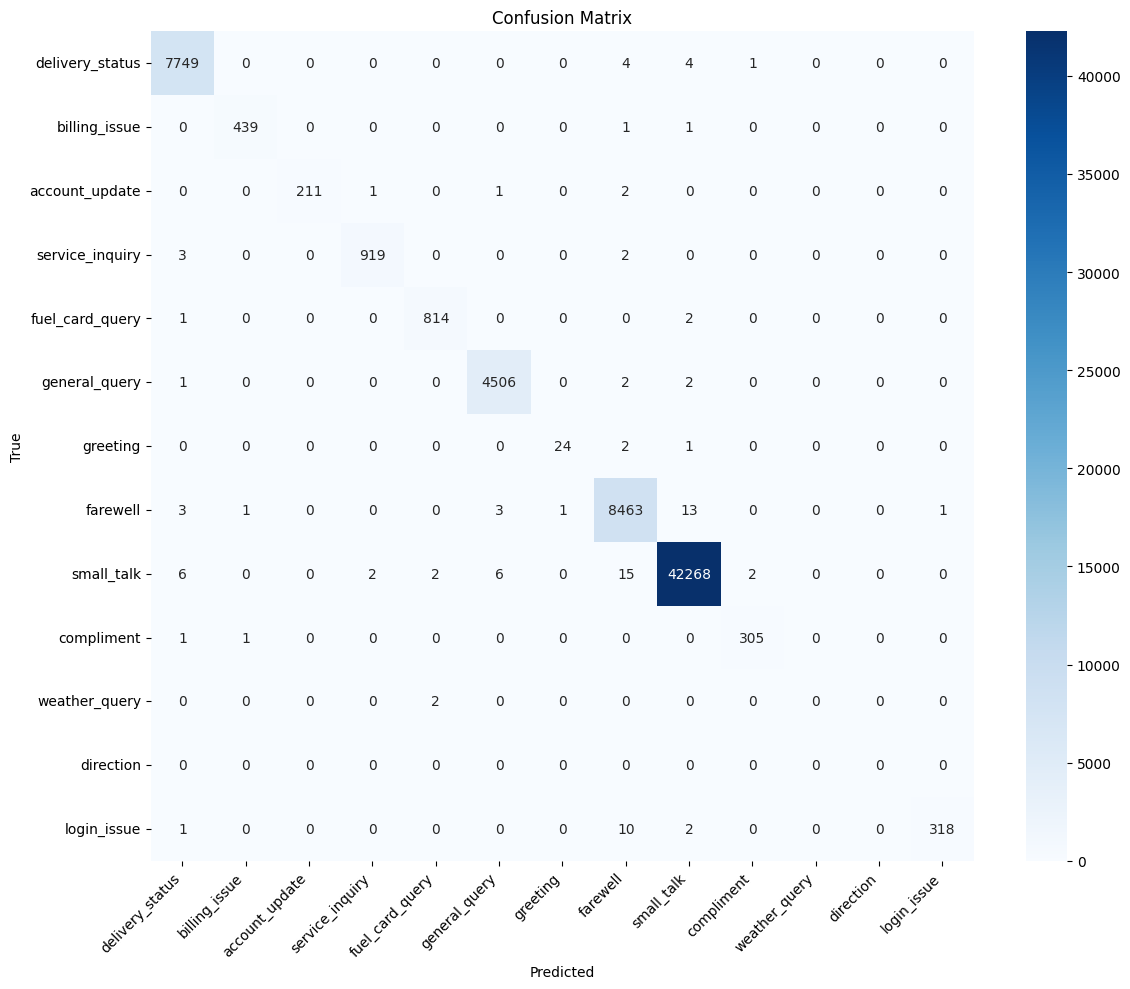

Evaluation Results:
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1-Score: 0.9984

Classification Report:
                 precision    recall  f1-score   support

delivery_status       1.00      1.00      1.00      7758
  billing_issue       1.00      1.00      1.00       441
 account_update       1.00      0.98      0.99       215
service_inquiry       1.00      0.99      1.00       924
fuel_card_query       1.00      1.00      1.00       817
  general_query       1.00      1.00      1.00      4511
       greeting       0.96      0.89      0.92        27
       farewell       1.00      1.00      1.00      8485
     small_talk       1.00      1.00      1.00     42301
     compliment       0.99      0.99      0.99       307
  weather_query       0.00      0.00      0.00         2
      direction       0.00      0.00      0.00         0
    login_issue       1.00      0.96      0.98       331

       accuracy                           1.00     66119
      macro avg       0.84      

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np
from collections import Counter

def evaluate_model(trainer, eval_dataset, label_map, unique_labels):
    """Evaluate the model on the evaluation dataset and compute metrics."""
    if trainer is None or eval_dataset is None:
        print("Error: Trainer or evaluation dataset is not available.")
        return None

    try:
        print("Evaluating model on evaluation dataset...")
        predictions = trainer.predict(eval_dataset)
        logits = predictions.predictions
        labels = predictions.label_ids
        preds = logits.argmax(axis=-1)

        # Validate labels
        unique_label_ids = [label_map[label] for label in unique_labels]
        invalid_labels = set(labels) - set(unique_label_ids)
        invalid_preds = set(preds) - set(unique_label_ids)
        if invalid_labels or invalid_preds:
            print(f"Warning: Invalid labels found in true labels: {invalid_labels}")
            print(f"Warning: Invalid labels found in predictions: {invalid_preds}")
            valid_mask = np.isin(labels, unique_label_ids) & np.isin(preds, unique_label_ids)
            labels = labels[valid_mask]
            preds = preds[valid_mask]
            if len(labels) == 0:
                print("Error: No valid labels remain after filtering.")
                return None

        # Log label distributions
        true_label_counts = Counter(labels)
        pred_label_counts = Counter(preds)
        print("True label distribution:", {unique_labels[id]: count for id, count in true_label_counts.items()})
        print("Predicted label distribution:", {unique_labels[id]: count for id, count in pred_label_counts.items()})

        # Compute confusion matrix
        cm = confusion_matrix(labels, preds, labels=unique_label_ids)
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Compute metrics with zero_division
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='weighted', zero_division=0
        )

        # Generate classification report
        label_names = [label for label in unique_labels]
        try:
            report = classification_report(
                labels, preds, target_names=label_names, labels=unique_label_ids, zero_division=0
            )
        except ValueError as e:
            print(f"Error generating classification report: {e}")
            report = "Classification report could not be generated."

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'classification_report': report,
            'confusion_matrix': cm.tolist()
        }

        print(f"Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)

        return results
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print(f"True labels unique values: {np.unique(labels)}")
        print(f"Predicted labels unique values: {np.unique(preds)}")
        print(f"Expected label IDs: {[label_map[label] for label in unique_labels]}")
        return None

# Run evaluation
if distilbert_trainer is not None and eval_dataset is not None:
    eval_results = evaluate_model(distilbert_trainer, eval_dataset, label_map, unique_labels)
else:
    print("Cannot evaluate: Trainer or evaluation dataset is not available.")

## Load saved model and reconstruct arguments for evaluate_model.

In [ ]:
import torch
import os
import json
import pandas as pd
import random
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

def load_and_prepare_eval_arguments(model_path='./chatbot_model', dataset_file='trucking_chatbot_test_dataset.csv'):
    """Load saved model and reconstruct arguments for evaluate_model."""
    try:
        # Load model and tokenizer
        print(f"Loading model and tokenizer from {model_path}")
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path, clean_up_tokenization_spaces=True)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Load unique labels
        labels_file = os.path.join(model_path, 'labels.json')
        if not os.path.exists(labels_file):
            print(f"Labels file {labels_file} not found. Using default labels.")
            unique_labels = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                             'fuel_card_query', 'general_query', 'greeting', 'small_talk',
                             'compliment', 'weather_query', 'direction', 'login_issue']
        else:
            with open(labels_file, 'r') as f:
                unique_labels = json.load(f)

        # Load or create label map
        label_map_file = os.path.join(model_path, 'label_map.json')
        if os.path.exists(label_map_file):
            with open(label_map_file, 'r') as f:
                label_map = json.load(f)
        else:
            print(f"Label map file {label_map_file} not found. Creating from unique labels.")
            label_map = {label: idx for idx, label in enumerate(unique_labels)}
            with open(label_map_file, 'w') as f:
                json.dump(label_map, f)
            print(f"Saved label_map to {label_map_file}")

        # Load and prepare dataset
        print(f"Loading dataset from {dataset_file}")
        try:
            df = pd.read_csv(dataset_file)
        except FileNotFoundError:
            print('Dataset not found. Using Twitter dataset.')
            try:
                df = pd.read_csv('tweets.csv')
            except FileNotFoundError:
                print('Using default dataset.')
                data = {
                    'text': [
                        'Where is my shipment from Speedway?', 'Why is my Comdata bill so high?',
                        'Need to update my address for IFTA', 'What are your hauling rates?',
                        'Help with my account', 'Hello', 'How are you', 'How can I help you',
                        'Track my cargo', 'Overcharged on Comdata invoice', 'Hi there',
                        'Change my contact info', 'Tell me about Comdata services', 'Lost my shipment',
                        'Good morning', 'Thanks for the help', 'Bye', 'What’s new?',
                        'How’s it going?', 'How’s your day going?', 'Any big plans?',
                        'How’s the trucking life?', 'You’re awesome!', 'Great job!',
                        'How’s the weather there?', 'Is it raining?',
                        'How do I get to Chicago?', 'What’s the best route to Miami?',
                        'Directions to the nearest truck stop', 'Can you route me to Denver?',
                        'Address is not correct on card', 'Update my billing address',
                        'Wrong address on my account', 'Change address for fuel card',
                        'My Comdata card is not working', 'Comdata card declined at pump',
                        'Fix my Comdata card issue', 'Why isn’t my Comdata card accepted?',
                        'I am not able to login to the Driven website', 'Can’t access my account on Driven',
                        'Login error on the Driven website', 'Driven website login not working',
                        'I want to change my card pin on the Driven website', 'Update my fuel card PIN on Driven',
                        'Need to reset my card PIN for Driven', 'Change PIN for my Comdata card on Driven website'
                    ],
                    'intent': [
                        'delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                        'general_query', 'greeting', 'greeting', 'greeting', 'delivery_status',
                        'billing_issue', 'greeting', 'account_update', 'fuel_card_query',
                        'general_query', 'greeting', 'farewell', 'farewell', 'small_talk',
                        'small_talk', 'small_talk', 'small_talk', 'small_talk', 'compliment',
                        'compliment', 'weather_query', 'weather_query',
                        'direction', 'direction', 'direction', 'direction',
                        'account_update', 'account_update', 'account_update', 'account_update',
                        'fuel_card_query', 'fuel_card_query', 'fuel_card_query', 'fuel_card_query',
                        'login_issue', 'login_issue', 'login_issue', 'login_issue',
                        'account_update', 'account_update', 'account_update', 'account_update'
                    ]
                }
                df = pd.DataFrame(data)

        # Validate intents
        invalid_intents = set(df['intent']) - set(unique_labels)
        if invalid_intents:
            print(f"Warning: Invalid intents in dataset: {invalid_intents}. Filtering them out.")
            df = df[df['intent'].isin(unique_labels)]

        # Encode labels
        le = LabelEncoder()
        le.fit(unique_labels)
        df['label'] = le.transform(df['intent'])

        # Create evaluation dataset
        dataset = Dataset.from_pandas(df[['text', 'label']])
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        split_idx = int(0.8 * len(indices))
        eval_indices = indices[split_idx:]
        eval_dataset = dataset.select(eval_indices)
        print(f"Evaluation dataset size: {len(eval_dataset)}")

        # Verify labels
        eval_labels = eval_dataset['label']
        invalid_eval_labels = set(eval_labels) - set(range(len(unique_labels)))
        if invalid_eval_labels:
            print(f"Error: Invalid label IDs in eval_dataset: {invalid_eval_labels}")
            return None, None, None, None

        # Tokenize dataset
        def tokenize_function(example):
            try:
                tokenized = tokenizer(
                    example['text'],
                    padding='max_length',
                    truncation=True,
                    max_length=128,
                    return_tensors='pt',
                    clean_up_tokenization_spaces=True
                )
                return {
                    'input_ids': tokenized['input_ids'].squeeze(0),
                    'attention_mask': tokenized['attention_mask'].squeeze(0),
                    'labels': torch.tensor(example['label'], dtype=torch.long).to(device)
                }
            except Exception as e:
                print(f'Error in tokenize_function: {e}')
                raise

        print("Tokenizing evaluation dataset...")
        tokenized_eval_dataset = eval_dataset.map(
            tokenize_function,
            remove_columns=['text', 'label'],
            desc="Tokenizing eval dataset"
        )
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        print("Tokenization complete.")

        # Create trainer
        training_args = TrainingArguments(
            output_dir='./distilbert_results',
            per_device_eval_batch_size=4,
            eval_strategy='epoch',
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            eval_dataset=tokenized_eval_dataset,
            compute_metrics=compute_metrics
        )

        print("Successfully reconstructed trainer, eval_dataset, label_map, and unique_labels.")
        return trainer, tokenized_eval_dataset, label_map, unique_labels
    except Exception as e:
        print(f"Error reconstructing evaluation arguments: {e}")
        return None, None, None, None

# Reconstruct arguments and evaluate
trainer, eval_dataset, label_map, unique_labels = load_and_prepare_eval_arguments()
if trainer is not None and eval_dataset is not None:
    eval_results = evaluate_model(trainer, eval_dataset, label_map, unique_labels)
else:
    print("Failed to reconstruct arguments for evaluation.")

## Step 8: Dialogue Management


In [26]:
from pickle import NONE
device='cpu'
class DialogueManager:
    def __init__(self, model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.model = model
      self.model.to(device)
      model.eval()
      #print(f"Model is on device: {next(model.parameters()).device}")
      self.tokenizer = tokenizer
      self.dialoggpt_model = dialoggpt_model
      self.dialoggpt_model.to(device)
      self.dialoggpt_tokenizer = dialoggpt_tokenizer
      self.reverse_label_map = {v: k for k, v in label_map.items()}
      self.state = 'INITIAL'
      self.context = defaultdict(str)
      self.history = []
      self.fallback_responses = {
          'greeting': {
              'INITIAL': [
                  'Hello! How can I assist you with your trucking needs today?',
                  'Hi there! What can I help you with regarding your shipments or account?'
              ],
              'POST_GREETING': [
                  'Thanks for the greeting! How can I assist with your shipment or billing needs?',
                  'Nice to connect again! What’s on your mind today?'
              ]
          },
          'farewell': {
              'INITIAL': [
                  'Goodbye! Feel free to reach out if you need further assistance.',
                  'Thanks for connecting! Let me know if you have more questions later.'
              ]
          },
          'small_talk': {
              'INITIAL': {
                  'mood': ['My day’s going smoothly, thanks for asking! How’s yours?'],
                  'plans': ['No big plans here, just helping truckers! Got any big plans yourself?'],
                  'industry': ['Trucking life’s always moving! How’s it treating you these days?'],
                  'default': ['All’s well here, thanks for asking! Need help with your shipments?']
              }
          },
          'compliment': {
              'INITIAL': ['Thank you, that’s kind of you! How can I assist you today?']
          },
          'weather_query': {
              'INITIAL': ['Weather’s clear here, but I can check for your route! Where are you headed?']
          }
      }
      self.trucking_responses = {
          'delivery_status': {
              'INITIAL': 'I can check your shipment status for {location}. Please provide the shipment ID.',
              'AWAITING_SHIPMENT_ID': 'Could you share the shipment ID to proceed with tracking?',
              'PROVIDED_SHIPMENT_ID': 'Thank you. Shipment {shipment_id} is currently at {location}. Would you like the estimated arrival time?'
          },
          'billing_issue': {
              'INITIAL': 'Let’s review your billing issue with {company}. Is this about an overcharge or a payment concern?',
              'AWAITING_DETAILS': 'Can you provide the invoice number or {company} transaction amount?',
              'RESOLVING': 'I’ve noted a {amount} charge on your {company} invoice. Would you like to dispute this?'
          },
          'account_update': {
              'INITIAL': 'I can help update your account details for {regulation}. What information would you like to change?',
              'AWAITING_INFO': 'Please provide the new address or contact details for {regulation}.',
              'CONFIRMING': 'I have {new_info} for your {regulation} update. Please confirm to proceed.'
          },
          'service_inquiry': {
              'INITIAL': 'I can provide information on our services. Are you interested in flatbed, refrigerated, or bulk transport rates?',
              'AWAITING_SPECIFICS': 'Which service are you inquiring about: flatbed, refrigerated, or bulk transport?'
          },
          'fuel_card_query': {
              'INITIAL': 'I can assist with your {company} fuel card or {regulation} query. Is this about a balance, transaction, or compliance?',
              'AWAITING_DETAILS': 'Could you specify if this is a {company} card issue or a {regulation} tax question?'
          },
           'direction': {
              'INITIAL': 'I can assist with your direction query. Where are you headed to?',
              'AWAITING_DETAILS': 'Could you specify if fuel station are you looking for?'
          },
          'login_issue': {
              'INITIAL': 'I can assist with your login issue. When did you last try to login?',
              'AWAITING_DETAILS': 'Could you specify what exact error are you getting?'
          },
          'general_query': {
              'INITIAL': 'Could you clarify your request? I can help with delivery, billing, account updates, or {company}/{regulation} services.'
          }
      }

    def predict_intent(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        #print(f"predict_intent input_ids device: {input_ids.device}")
        #print(f"predict_intent attention_mask device: {attention_mask.device}")
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)
            predicted_class = torch.argmax(probs, dim=-1).to(device)  # Ensure device consistency
            predicted_class = predicted_class.item()  # Convert to scalar
            confidence = probs[0][predicted_class].item()
            # Log top 3 intents for debugging
            top_probs, top_indices = torch.topk(probs[0], 3)
            top_intents = [(unique_labels[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)]
            #print(f"Top 3 intents: {top_intents}")
        return self.reverse_label_map.get(predicted_class, 'general_query')  # Fallback to general_query

    def extract_entities(self, text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        if 'ifta' in text:
            entities.append({'entity': 'regulation', 'value': 'IFTA'})
        shipment_match = re.search(r'\bship\d+\b', text, re.IGNORECASE)
        if shipment_match:
            entities.append({'entity': 'shipment_id', 'value': shipment_match.group()})
        amount_match = re.search(r'\$\d+', text)
        if amount_match:
            entities.append({'entity': 'amount', 'value': amount_match.group()})
        direction_match = re.search(r'\bgo\d+\b | \bturn\d+\b | \bdirection\d+\b', text, re.IGNORECASE)
        if direction_match:
            entities.append({'entity': 'direction', 'value': direction_match.group()})
        if 'new address' in text or 'change to' in text:
            new_info = text.split('new address')[-1].strip() or text.split('change to')[-1].strip()
            entities.append({'entity': 'new_info', 'value': new_info[:50]})
        if 'driven' in text:
                entities.append({'entity': 'website', 'value': 'Driven'})
        if 'pin' in text:
                entities.append({'entity': 'pin', 'value': 'pin'})
        if any(word in text for word in ['login', 'sign in', 'access']):
                entities.append({'entity': 'login', 'value': 'login'})
        return entities

    def get_dialoggpt_response(self, text):
        try:
            if self.dialoggpt_tokenizer.pad_token is None:
                self.dialoggpt_tokenizer.pad_token = self.dialoggpt_tokenizer.eos_token
            input_ids = self.dialoggpt_tokenizer.encode(text + self.dialoggpt_tokenizer.eos_token, return_tensors='pt')
            input_ids = input_ids.to(device)
            #print(f"get_dialoggpt_response: input_ids device: {input_ids.device}")
            reply_ids = self.dialoggpt_model.generate(
                input_ids,
                max_new_tokens=128,
                pad_token_id=self.dialoggpt_tokenizer.eos_token_id,
                no_repeat_ngram_size=3,
                top_p=0.9,
                temperature=0.7,
                do_sample=True
            )
            #print(f"get_dialoggpt_response: reply_ids device: {reply_ids.device}")
            response = self.dialoggpt_tokenizer.decode(reply_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True)
            #print(f"get_dialoggpt_response: response device: {response.device}")
            return response
        except Exception as e:
            print(f'Error getting DialogGPT response: {e}')
            return None

    def update_context(self, intent, entities, text):
        self.history.append((intent, text, ''))
        for entity in entities:
            self.context[entity['entity']] = entity['value']
        if intent == 'greeting':
            self.context['greeted'] = 'true'
        if intent == 'small_talk':
            text = text.lower()
            if 'day' in text or 'how’s your day' in text:
                self.context['small_talk_type'] = 'mood'
            elif 'plans' in text or 'big plans' in text:
                self.context['small_talk_type'] = 'plans'
            elif 'trucking' in text or 'truck' in text:
                self.context['small_talk_type'] = 'industry'
            else:
                self.context['small_talk_type'] = 'default'

    def transition_state(self, intent, entities, text):
        if intent in ['greeting', 'small_talk', 'compliment', 'weather_query']:
            self.state = 'POST_GREETING' if self.state == 'INITIAL' and intent == 'greeting' else self.state
        elif intent == 'farewell':
            self.state = 'INITIAL'
        elif intent == 'delivery_status':
            if self.state == 'INITIAL' and 'shipment_id' not in self.context:
                self.state = 'AWAITING_SHIPMENT_ID'
            elif 'shipment_id' in self.context:
                self.state = 'PROVIDED_SHIPMENT_ID'
        elif intent == 'billing_issue':
            if self.state == 'INITIAL' and not any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'AWAITING_DETAILS'
            elif any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'RESOLVING'
        elif intent == 'account_update':
            if self.state == 'INITIAL' and 'new_info' not in self.context:
                self.state = 'AWAITING_INFO'
            elif 'new_info' in self.context:
                self.state = 'CONFIRMING'
        elif intent == 'service_inquiry':
            if self.state == 'INITIAL' and 'service_type' not in self.context:
                self.state = 'AWAITING_SPECIFICS'
        elif intent == 'fuel_card_query':
            if self.state == 'INITIAL' and not any(e['entity'] in ['balance', 'transaction'] for e in entities):
                self.state = 'AWAITING_DETAILS'
        elif intent == 'direction':
            if self.state == 'INITIAL' and not any(e['entity'] in ['area', 'fuelstation'] for e in entities):
                self.state = 'AWAITING_DETAILS'
        elif intent == 'login_issue':
            if self.state == 'INITIAL' and not any(e['entity'] in ['login', 'error'] for e in entities):
                self.state = 'AWAITING_DETAILS'

    def generate_response(self, intent, entities, text):
        self.update_context(intent, entities, text)
        self.transition_state(intent, entities, text)

        if intent in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']:
            dialog_response = self.get_dialoggpt_response(text)
            if not dialog_response or len(dialog_response) < 5 or any(word in dialog_response.lower() for word in ['inappropriate', 'sorry', 'weird', 'lol']):
                small_talk_type = self.context.get('small_talk_type', 'default')
                if intent == 'small_talk':
                    response_options = self.fallback_responses[intent]['INITIAL'].get(small_talk_type, self.fallback_responses[intent]['INITIAL']['default'])
                else:
                    response_options = self.fallback_responses.get(intent, {'INITIAL': ['Could you clarify your request?']}).get(self.state, self.fallback_responses[intent]['INITIAL'])
                response = random.choice(response_options) if isinstance(response_options, list) else response_options
            else:
                response = dialog_response + ' Need assistance with your trucking needs?'
            if intent == 'greeting' and 'good morning' in text.lower() and datetime.now().hour < 12:
                response = random.choice(['Good morning to you too! How can I assist today?', 'Morning! Ready to help with your trucking needs.'])
        else:
            response_template = self.trucking_responses.get(intent, self.trucking_responses['general_query']).get(self.state, self.trucking_responses[intent]['INITIAL'])
            try:
                response = response_template.format(
                    location=self.context.get('location', 'unknown'),
                    company=self.context.get('company', 'unknown'),
                    regulation=self.context.get('regulation', 'unknown'),
                    shipment_id=self.context.get('shipment_id', 'unknown'),
                    amount=self.context.get('amount', 'unknown'),
                    new_info=self.context.get('new_info', 'unknown')
                )
            except KeyError:
                print("keyerror:"+KeyError)
                response = response_template

        if self.context.get('greeted') == 'true' and intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'] and 'PROVIDED' in self.state:
            response = f'Since you greeted me earlier, I’m ready to assist! {response}'

        self.history[-1] = (intent, text, response)
        resolved = self.state in ['PROVIDED_SHIPMENT_ID', 'RESOLVING', 'CONFIRMING'] and intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
        return response, resolved

    def evaluate_dialogue_success(self):
        resolved = sum(1 for intent, _, _ in self.history if intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'] and self.state in ['PROVIDED_SHIPMENT_ID', 'RESOLVING', 'CONFIRMING'])
        total = sum(1 for intent, _, _ in self.history if intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'])
        return resolved / total if total > 0 else 0.0

try:
  if label_map is NONE:
    with open('label_map.json', 'r') as f:
        label_map = json.load(f)
  else:
    dialogue_manager = DialogueManager(distilbert_model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer)
except FileNotFoundError:
    print('Error: label_map.json not found. Please ensure Cell 6 has run successfully.')
    dialogue_manager = None



## Step 9: Interactive Chatbot UI

UI with DialogGPT conversational support trained on Twitter data.

In [27]:
if dialogue_manager is None:
    print('Dialogue manager not initialized. Please fix previous errors.')
else:
    # Create UI
    input_box = widgets.Text(
        value='',
        placeholder='Type your query (e.g., Hello, How’s your day?, or Where’s my shipment?)',
        description='Query:',
        layout={'width': '500px'}
    )
    submit_button = widgets.Button(
        description='Submit',
        button_style='success',
        tooltip='Submit query'
    )
    follow_up_button1 = widgets.Button(
        description='Request ETA',
        button_style='info',
        tooltip='Request ETA',
        layout={'visibility': 'hidden'}
    )
    follow_up_button2 = widgets.Button(
        description='Confirm',
        button_style='success',
        tooltip='Confirm action',
        layout={'visibility': 'hidden'}
    )
    output_area = widgets.Output()

    def on_submit_clicked(b):
        with output_area:
            clear_output()
            user_input = input_box.value.strip()
            if not user_input:
                print('Please enter a query.')
                return
            print(f'You: {user_input}')
            try:
                intent = dialogue_manager.predict_intent(user_input)
                entities = dialogue_manager.extract_entities(user_input)
                print(f'Intent:{intent} Entity:{entities}')
                response, resolved = dialogue_manager.generate_response(intent, entities, user_input)
                print(f'Bot: {response}')
                input_box.value = ''
                follow_up_button1.layout.visibility = 'visible' if dialogue_manager.state == 'PROVIDED_SHIPMENT_ID' else 'hidden'
                follow_up_button2.layout.visibility = 'visible' if dialogue_manager.state in ['RESOLVING', 'CONFIRMING'] else 'hidden'
                success_rate = dialogue_manager.evaluate_dialogue_success()
                if success_rate > 0:
                    print(f'Dialogue Success Rate: {success_rate:.2f}')
            except Exception as e:
                print(f'Error processing query: {e}')

    def on_follow_up1_clicked(b):
        with output_area:
            clear_output()
            response = f'The estimated arrival time for shipment {dialogue_manager.context.get("shipment_id", "unknown")} is tomorrow by 3 PM.'
            dialogue_manager.history.append(('follow_up', 'Request ETA', response))
            print(f'Bot: {response}')
            follow_up_button1.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    def on_follow_up2_clicked(b):
        with output_area:
            clear_output()
            if dialogue_manager.state == 'CONFIRMING':
                response = f'Confirmed. {dialogue_manager.context.get("new_info", "action")} has been updated.'
            else:
                response = f'Dispute for {dialogue_manager.context.get("amount", "unknown")} has been submitted.'
            dialogue_manager.history.append(('follow_up', 'Confirm', response))
            dialogue_manager.state = 'INITIAL'
            print(f'Bot: {response}')
            follow_up_button2.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    submit_button.on_click(on_submit_clicked)
    follow_up_button1.on_click(on_follow_up1_clicked)
    follow_up_button2.on_click(on_follow_up2_clicked)

    # Display UI
    display(widgets.VBox([
        widgets.HTML('<h3>Trucking Co. Customer Chatbot</h3>'),
        input_box,
        submit_button,
        follow_up_button1,
        follow_up_button2,
        output_area
    ]))
    print('Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.')
    print('Type your query and click Submit.')


Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.
Type your query and click Submit.
